## packages

In [344]:
# import libraries
import requests
import time
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
import holoviews as hv
from holoviews import opts, dim
import matplotlib
import matplotlib.pyplot as plt
import squarify

%load_ext rpy2.ipython
%autosave 120
%R library(circlize)
%R library(RColorBrewer)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Autosaving every 120 seconds


array(['RColorBrewer', 'circlize', 'tools', 'stats', 'graphics',
       'grDevices', 'utils', 'datasets', 'methods', 'base'], dtype='<U12')

## start here after scraping

In [345]:
dfCSV = pd.read_csv('HPff.csv')
df = pd.read_csv('HPff.csv')
pd.isnull(df).any(1).nonzero()[0]
df = df[(df['Ship'].str.contains('/')) | (df['Ship'].str.contains('&'))]
df['Ship'] = df['Ship'].str.replace(r"\(.*\)","") #remove anything in ()

In [346]:
dfCSV.head()

Unnamed: 0                                     Ship         Date
0           0           Hermione Granger/Severus Snape  03 Apr 2019
1           1  Severus Snape/Minerva McGonagall (past)  03 Apr 2019
2           2            Sirius Black/Hermione Granger  03 Apr 2019
3           3          Sirius Black & Hermione Granger  03 Apr 2019
4           4           Hermione Granger/Severus Snape  03 Apr 2019

In [347]:
individuals = df["Ship"].str.split(r'[/&]', expand = True) 

personColumns = []
for i in range(0,7):
    df[f"Person {i+1}"] = individuals[i]
    personColumns.append(f"Person {i+1}")

df = df.reset_index(drop=True)

In [502]:
df.head()

['Harry', 'Draco', 'Hermione', 'OC', 'Sirius', 'Remus', 'Snape', 'Newt', 'Ron', 'Tom Riddle', 'James', 'Ginny', 'Lily', 'Credence', 'Luna', 'Tina', 'Grindelwald', 'Lucius', 'Scorpius', 'Neville', 'Pansy', 'Dumbledore', 'Narcissa', 'Blaise', 'Reader', 'Tonks', 'Albus Severus', 'Fred', 'Theseus', 'George', 'Queenie', 'Bellatrix', 'Nott', 'Charlie', 'Dean', 'Bill', 'Seamus', 'Astoria', 'Oliver', 'Teddy', 'James Sirius', 'Jacob Kowalski', 'Fleur', 'Percy', 'Regulus Black', 'Daphne', 'Lavender', 'Arthur', 'McGonagall', 'Cedric', 'Molly', 'Krum', 'Peter', 'Marcus Flint', 'Rose', 'Cho', 'Angelina', 'Hannah', 'Marlene McKinnon', 'Lily Luna', 'Petunia', 'Parvati', 'Rodolphus Lestrange', 'Other', 'Regulus Black ', 'Leta Lestrange', 'Victoire', 'Lee', 'Dudley', 'Katie', 'OMC', 'Susan Bones', 'Padma', 'Fenrir Greyback', 'Vernon', 'Dorcas Meadowes', 'Kingsley', 'Rabastan Lestrange', 'Leta Lestrange ', 'Millicent Bulstrode', 'Salazar Slytherin', 'OFC', 'Cormac McLaggen', 'Goyle', 'Rolf Scamander', '

In [503]:
mainCharacters = ['Harry', 'Ron', 'Hermione', 'Luna', 'Neville', 'Ginny', 'Angelina', 'Alicia', 
                  'Lavender', 'Katie', 'Lee', 'Oliver', 'Parvati', 'Padma', 'Seamus', 'Dean', 'Hannah', 'Colin', 'Cho', 'Cedric', 'Gabrielle',
                  'Snape', 'Sirius', 'McGonagall', 'Dumbledore', 'Hagrid', 'Remus', 'Tom', 'Kingsley', 'Tonks', 'Slughorn', 
                  'Umbridge', 'Myrtle', 'Dobby', 'Nagini', 'Draco', 'Lucius','Petunia','Vernon','Victoire',
                  'Astoria', 'Daphne', 'Grabbe', 'Goyle', 'Blaise', 'Narcissa', 'Pansy', 'Fleur', 'Krum', 'Regulus', 'Marcus'
                  'Charlie', 'Bill', 'George', 'Fred', 'Percy', 'Arthur', 'Molly', 'Lily', 'James', 'Peter', 'Dudley', 'Bellatrix', 'Lockhart', 'Moody', 'Theodore', 
                  'Rose', 'Teddy', 'Hugo', 'Grindelwald', 'Newt','Scorpius', 'Theseus','Queenie','Tina','Credence']

originalSeries = ['Harry', 'Ron', 'Hermione', 'Luna', 'Neville', 'Ginny', 'Angelina', 'Alicia', 'Regulus', 'Theodore','Marcus', 
                  'Lavender', 'Katie', 'Lee', 'Oliver', 'Parvati', 'Padma', 'Seamus', 'Dean', 'Hannah', 'Colin', 'Cho', 'Cedric',
                  'Snape', 'Sirius', 'McGonagall', 'Dumbledore', 'Hagrid', 'Remus', 'Tom', 'Kingsley', 'Tonks', 'Slughorn', 'Gabrielle',
                  'Umbridge', 'Myrtle', 'Dobby', 'Nagini', 'Draco', 'Lucius', 'Tina', 'Credence',
                  'Grabbe', 'Goyle', 'Blaise', 'Narcissa', 'Pansy', 'Fleur', 'Krum', 'Petunia','Vernon'
                  'Charlie', 'Bill', 'George', 'Fred', 'Percy', 'Arthur', 'Molly', 'Peter', 'Dudley', 'Bellatrix', 'Lockhart', 'Moody']

nextGeneration = ['Rose', 'Teddy', 'Hugo','Scorpius', 'Theseus','Victoire']

fantasticBeasts = ['Grindelwald', 'Dumbledore', 'Theseus', 'Queenie','Tina','Credence']

#super hackey to separate same names from different gens
repeats = ['Albus Severus', 'Lily Luna', 'James Sirius']
repeatsPlaceholder = ['kid1', 'kid2', 'kid3']

In [350]:
def pickingCharacters(generation):
    for i in personColumns:
        for j in range(0,len(repeats)):
            df.loc[df[i].str.contains(repeats[j], case=False, na=False), i] = repeatsPlaceholder[j]
            
        for j in range(0,len(generation)):
            df.loc[df[i].str.contains(mainCharacters[j], case=False, na=False), i] = mainCharacters[j]

        for k in range(0,len(repeats)): #This way all the 'Albus's aren't grouped with kid albus
            df.loc[df[i].str.contains(repeatsPlaceholder[k], case=False, na=False), i] = repeats[k]

        df.loc[df[i].str.contains('Original', case=False, na=False), i] = 'OC'
        df.loc[df[i].str.contains('Character', case=False, na=False), i] = 'OC'

        df.loc[df[i].str.contains('Reader', case=False, na=False), i] = 'Reader'
        df.loc[df[i].str.contains('you', case=False, na=False), i] = 'Reader'

        
        df.loc[df[i].str.contains('Tom', case=False, na=False), i] = 'Tom Riddle'
        df.loc[df[i].str.contains('Voldemort', case=False, na=False), i] = 'Tom Riddle'

pickingCharacters(mainCharacters)

In [351]:
dfCSV.tail()

Unnamed: 0                                  Ship         Date
115213      115213      Queenie Goldstein/Jacob Kowalski  22 Nov 2016
115214      115214             Draco Malfoy/Harry Potter  22 Nov 2016
115215      115215  Scorpius Malfoy/Albus Severus Potter  22 Nov 2016
115216      115216         Hermione Granger/Draco Malfoy  22 Nov 2016
115217      115217         Hermione Granger/Draco Malfoy  22 Nov 2016

In [352]:
#threshold = 20
#toRemove = value_counts[value_counts <= threshold].index
#for i in personColumns:
#    df[i].replace(toRemove, np.nan, inplace=True)

In [353]:
value_counts = df[personColumns].stack().value_counts()

In [354]:
topAll = value_counts.index.tolist()
top10 = value_counts.index[:10].tolist()
top11 = value_counts.index[:11].tolist()
top20 = value_counts.index[:20].tolist()
top50 = value_counts.index[:50].tolist()
top100 = value_counts.index[:100].tolist()

In [355]:
topNumber = top100

dfAdj = pd.DataFrame(index=top100, columns=top100)
dfAdj = dfAdj.fillna(0) 

for i in range(df.shape[0]):
    if df.at[i,'Person 1'] in topNumber and df.at[i,'Person 2'] in topNumber:
        indexPerson = df.at[i,'Person 1']
        columnPerson = df.at[i,'Person 2']
        dfAdj.at[indexPerson, columnPerson] += 1

In [356]:
topNumber = top100

dfPairings = pd.DataFrame(columns=['Character','Partner','Stories'], index = [0])

first = True
for i in topNumber:
    for j in topNumber:
        if i != j:
            hits = dfAdj.at[i,j] + dfAdj.at[j,i]
            if first == True:
                dfPairings.loc[0] = [i,j,hits]
                first = False
            else: 
                dfPairings.loc[dfPairings.index.max() + 1] = [i,j,hits]
                
dfPairings = dfPairings.sort_values(['Character','Partner'],ascending=[True,False])
dfPairings.head()

Character     Partner Stories
8481  Abraxas Malfoy    Victoire       0
8489  Abraxas Malfoy      Vernon       0
8440  Abraxas Malfoy       Tonks       0
8424  Abraxas Malfoy  Tom Riddle      58
8430  Abraxas Malfoy        Tina       0

In [357]:
def IndividualStats(Person,Bar,Tree):
    
    dfPerson = dfPairings.loc[dfPairings['Character'] == Person]
    dfPerson = dfPerson.sort_values(['Stories'],ascending=[False])
    dfPerson = dfPerson.reset_index(drop=True)

    Total = dfPerson['Stories'].sum()
    Other = 0
    for i, row in dfPerson.iterrows():
        if row['Stories'] < Total*.0075:
            Other += row['Stories']
            dfPerson = dfPerson.drop(i)

    dfPerson = dfPerson.reset_index(drop=True)
    dfPerson.loc[dfPerson.index.max() + 1] = [Person,'Other',Other]
    
    if Bar == True:
        dfPersonPivot = dfPerson.pivot(index='Character', columns='Partner', values='Stories')
        dfPersonPivot = dfPersonPivot[dfPersonPivot.sum().sort_values().index]
        with plt.style.context('ggplot'):
            dfPersonPivot.plot(kind='barh')
            
    if Tree == True:  
        plt.figure()
        norm = matplotlib.colors.Normalize(vmin=min(dfPerson['Stories']), vmax=max(dfPerson['Stories']))
        colors = [matplotlib.cm.Reds(norm(value)) for value in dfPerson['Stories']]

        squarify.plot(sizes=dfPerson['Stories'], label=dfPerson['Partner'],color=colors, alpha=.4,linewidth=2, edgecolor="#000000")
        plt.axis('off')
        plt.show()

## R chord

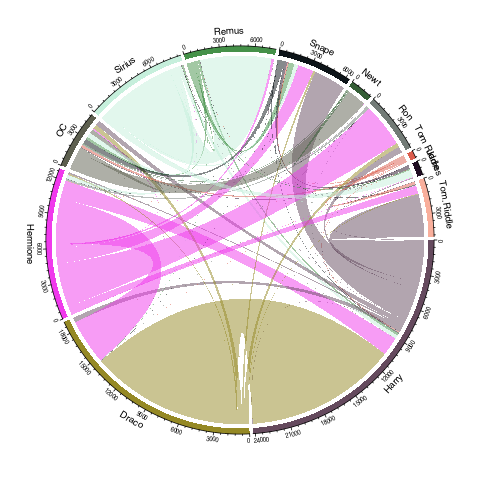

In [358]:
dfTop11 = dfAdj.iloc[:11]
dfTop11 = dfTop11[top50[:11]]

%R -i dfTop11
%R chordDiagram(dfTop11)
%R circos.clear()

## HoloViews Chord

In [359]:
topNumber = top100

dfChord = pd.DataFrame(columns=['Character','Partner','Stories'], index = [0])

first = True
for i in topNumber:
    for j in topNumber:
        if i != j:
            hits = dfAdj.at[i,j] + dfAdj.at[j,i]
            if first == True:
                dfChord.loc[0] = [i,j,hits]
                first = False
            else: 
                dfChord.loc[dfChord.index.max() + 1] = [i,j,hits]

#removes duplicates from chord diagram
row = 0                
while row < dfChord.shape[0]:
    for i in topNumber:
        for j in topNumber:
            if dfChord.at[row,'Character'] == i and dfChord.at[row,'Partner'] == j:
                row2 = 0
                while row2 < dfChord.shape[0]:
                    if dfChord.at[row2,'Character'] == j and dfChord.at[row2,'Partner'] == i:
                        dfChord = dfChord.drop(row2)
                        dfChord = dfChord.reset_index(drop=True)
                    row2 += 1
    row += 1

dfChord['Stories'] = dfChord['Stories'].astype(str).astype(int)
dfPairings['Stories'] = dfPairings['Stories'].astype(str).astype(int)

In [360]:
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    display(dfChord)
# df["period"] = dataframe["Year"].map(str) + dataframe["quarter"]
dfCombinedNames = dfChord.copy()
dfCombinedNames['Ship'] = dfChord["Character"].map(str) + '/' + dfChord["Partner"].map(str)
dfCombinedNames = dfCombinedNames[['Ship','Stories']]
dfCombinedNames = dfCombinedNames.sort_values(['Stories'],ascending=[False])
dfCombinedNames = dfCombinedNames.reset_index(drop=True)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
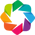

In [361]:
hv.extension('bokeh')
hv.output(size=200)

In [362]:
chord = hv.Chord(dfChord)
chord.opts(
    opts.Chord(cmap='Category20', edge_cmap='Category20', edge_color=dim('Character').str(), 
               labels='index', node_color=dim('index').str()))

#hv.save(chord, 'chordHP.html')

:Chord   [Character,Partner]   (Stories)

## Bar Plots (in development)

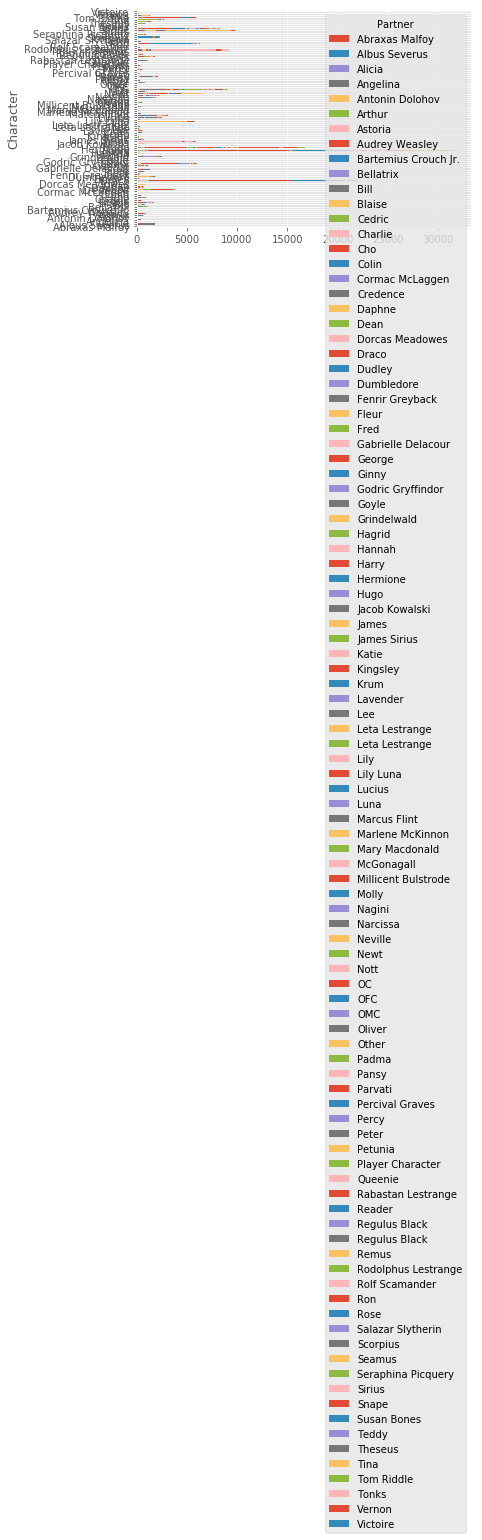

In [363]:
with plt.style.context('ggplot'):
    dfPairings.pivot(index='Character', columns='Partner', values='Stories').plot(kind='barh',stacked=True)

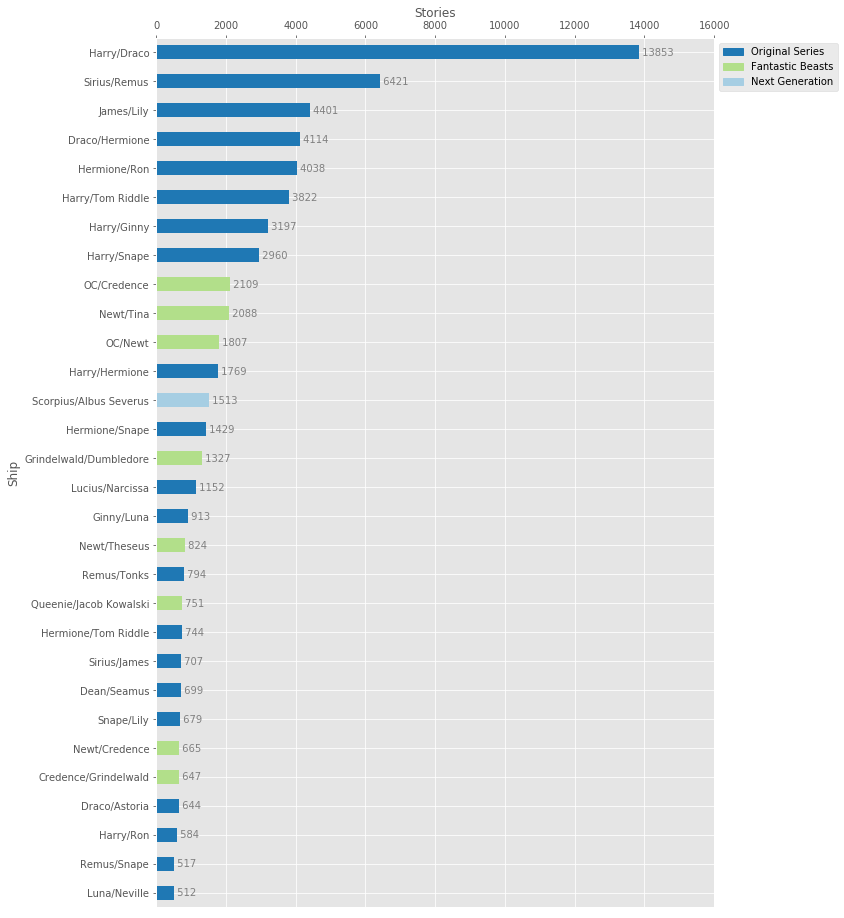

In [374]:
#oc*8 mov*2 new*1 oc*1 mov*2 oc*3 mov*1 oc*1 mov*1 oc*5, mov*1, oc*3, mov*1, oc*8, mov*1, oc*4 new*1 oc*3 mov*2
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

new = '#a6cee3'
oc = '#1f78b4'
mov = '#b2df8a'

OC = mpatches.Patch(color=oc, label='Original Series')
MOV = mpatches.Patch(color=mov, label='Fantastic Beasts')
NEW = mpatches.Patch(color=new, label='Next Generation')

dfCombinedNamesPlot = dfCombinedNames[:30]
dfCombinedNamesPlot = dfCombinedNamesPlot.sort_values(['Stories'],)

colorList30 =(oc,oc,oc,oc,oc,oc,oc,oc,oc,mov,mov,mov,oc,new,oc,mov,oc,oc,mov,oc,mov,oc,oc,oc,oc,mov,mov,oc,oc,oc,oc)
colorList = (oc,oc,oc,oc,oc,oc,oc,oc,mov,mov,oc,new,oc,mov,mov,oc,oc,oc,mov,oc,mov,oc,oc,oc,oc,oc,mov,oc,oc,oc,mov,oc,oc,oc,oc,oc,oc,oc,oc,mov,oc,oc,oc,oc,new,oc,oc,oc,mov,mov)

#fig, ax = subplots()
with plt.style.context('ggplot'):
    ax = dfCombinedNamesPlot.plot(kind='barh',x='Ship',figsize=(10,16),color=[list(reversed(colorList30))])
    ax.legend(handles=[OC,MOV,NEW],bbox_to_anchor=(1,1))
    ax.set_xlabel("Stories")
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    for i, v in enumerate(dfCombinedNamesPlot['Stories']):
        ax.text(v, i, " "+str(v), color='grey', va='center')
    ax.set_xticks(range(0,18000,2000))

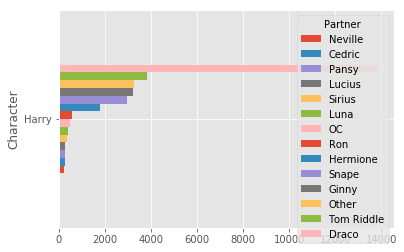

In [365]:
IndividualStats('Harry',True,False)

## treemap

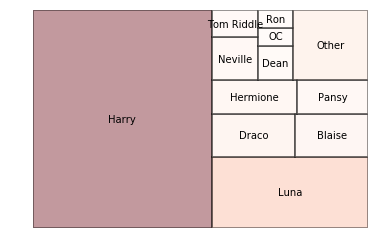

In [396]:
IndividualStats('Ginny',False,True)

In [ ]:
Gryf = ['Harry','Hermione','Sirius','Remus','Ron','James','Ginny','Lily','Neville','Dumbledore','Fred','George','Charlie','Dean','Bill','Seamus','Oliver','James Sirius','Percy','Lavender','Arthur','McGonagall']
Slyth = ['Draco','Snape','Tom Riddle','Lucius','Scorpius','Pansy','Narcissa','Blaise','Albus Severus','Bellatrix','Theodore','Astoria','Regulus','Daphne']
Huff = ['Newt','Tonks','Teddy','Cedric']
Rav = ['Luna','Cho']

In [510]:
def MultipleStats(List):
    fig = plt.figure(figsize=(40, 160))
    for i in List:
        dfPerson = dfPairings.loc[dfPairings['Character'] == i]
        dfPerson = dfPerson.sort_values(['Stories'],ascending=[False])
        dfPerson = dfPerson.reset_index(drop=True)

        Total = dfPerson['Stories'].sum()
        Other = 0
        for j, row in dfPerson.iterrows():
            if row['Stories'] < Total*.0075:
                Other += row['Stories']
                dfPerson = dfPerson.drop(j)

        dfPerson = dfPerson.reset_index(drop=True)
        dfPerson.loc[dfPerson.index.max() + 1] = [j,'Other',Other]
        
        with plt.style.context('ggplot'):
            
            norm = matplotlib.colors.Normalize(vmin=min(dfPerson['Stories']), vmax=max(dfPerson['Stories']))
            if i in Gryf:
                colors = [matplotlib.cm.Reds(norm(value)) for value in dfPerson['Stories']]
            elif i in Rav:
                colors = [matplotlib.cm.Blues(norm(value)) for value in dfPerson['Stories']]
            elif i in Slyth:
                colors = [matplotlib.cm.Greens(norm(value)) for value in dfPerson['Stories']]     
            elif i in Huff:
                colors = [matplotlib.cm.YlOrBr(norm(value)) for value in dfPerson['Stories']] 
            else:
                colors = [matplotlib.cm.Greys(norm(value)) for value in dfPerson['Stories']] 

            axes = fig.add_subplot(20,3,(List.index(i)+1))
            squarify.plot(sizes=dfPerson['Stories'], ax=axes, label=dfPerson['Partner'],color=colors, alpha=.5,linewidth=2, edgecolor="#000000")
            axes.set_title(i)
            plt.axis('off')
            
    plt.show()

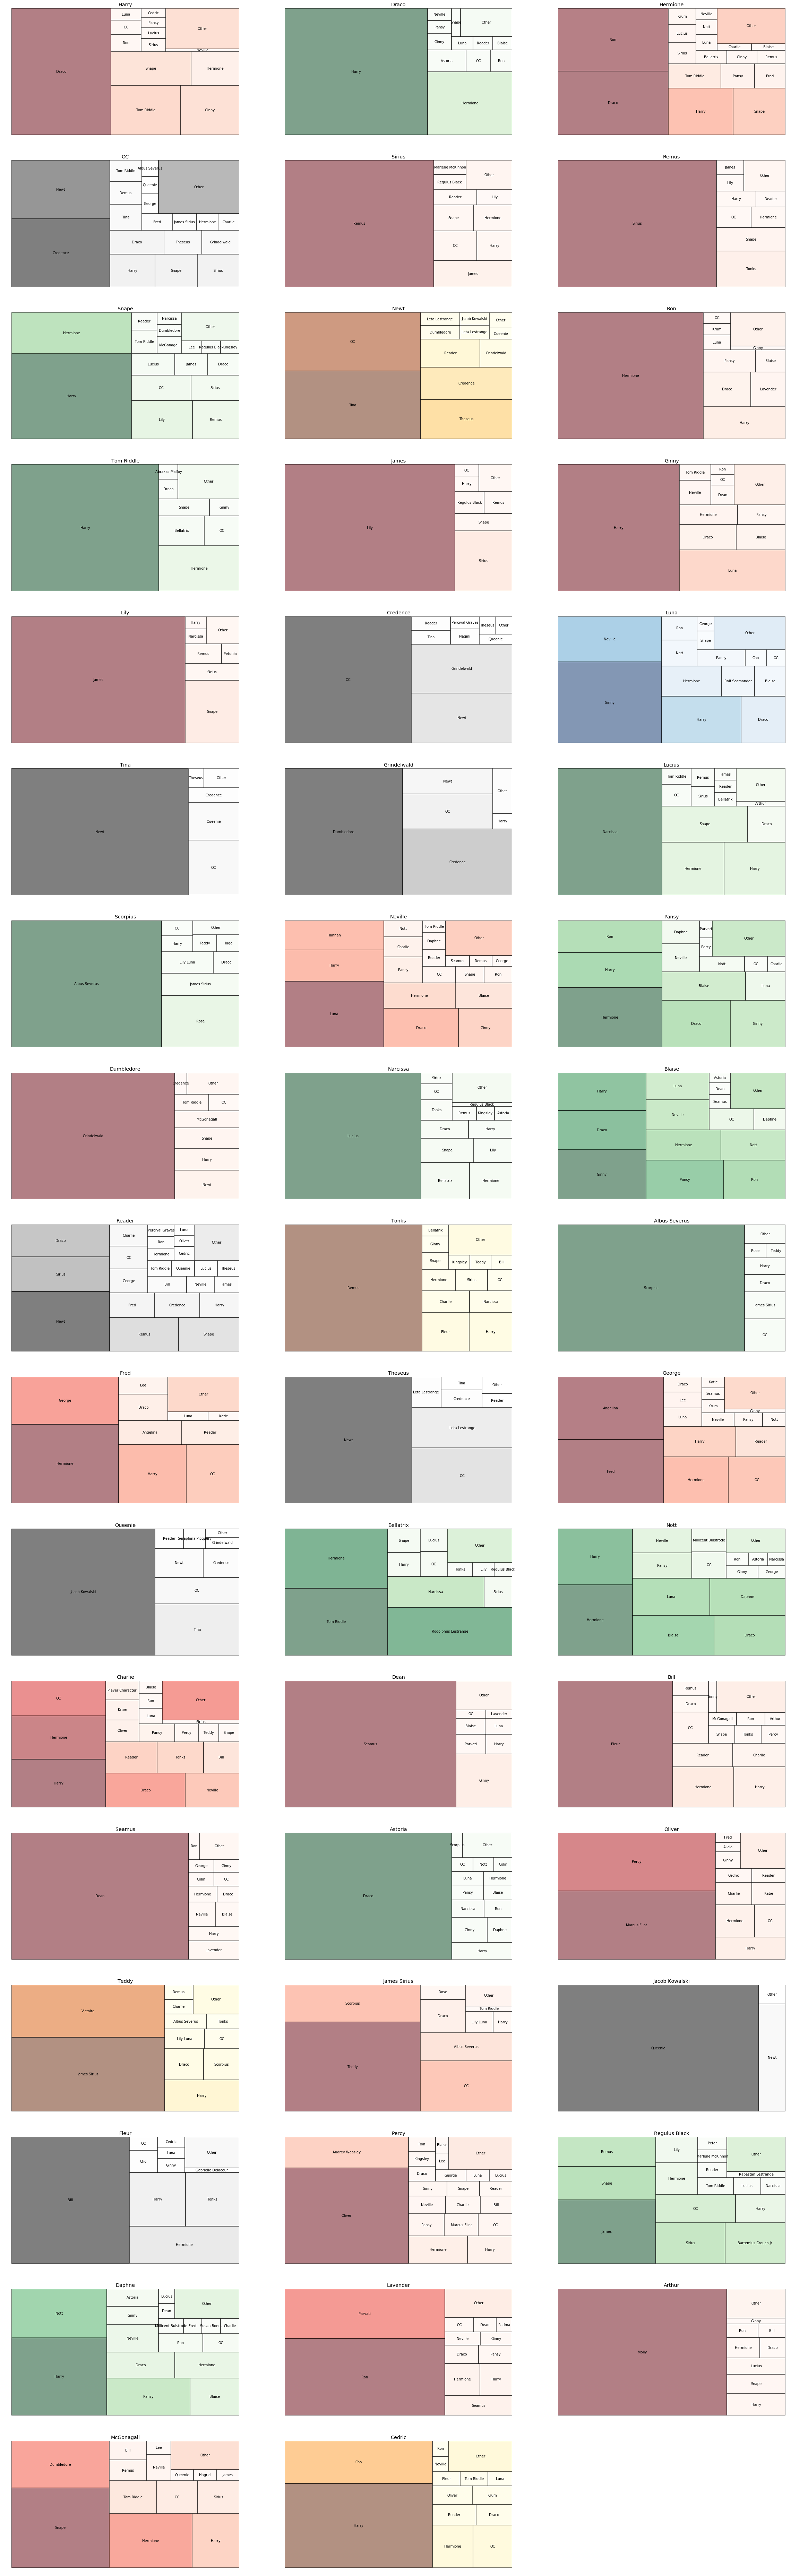

In [511]:
MultipleStats(top50)